# Introduction

This notebook serves to employ training and finetuning a pre-trained VGG16 model to classify images of varrying human emotions. There are 7 emotions in the dataset: 
1) Angry
2) Disgusted
3) Fearful
4) Happy
5) Neutral
6) Sad
7) Surprised

The motivation behind this project is from the difficulty of having to intepret our partners' emotions. Knowing their current emotions can help us better direct our actions to keep them as happy as possible so that we stay strong as a couple.

This setup and data preparation portion of this codebase was adapted from https://www.kaggle.com/code/odins0n/emotion-detection.

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import os
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = "data/emotion_dataset/train"
val_dir = "data/emotion_dataset/test"
models_dir_path = "models/"

random_seed = 12
img_height = 48
img_width = 48
batch_size = 32
num_epochs = 50
num_finetuning_epochs = 25
learning_rate = 0.001
finetuning_learning_rate = 0.0001
num_classes = 7
early_stop_criteria = 5

# Data Preparation

Added some data augmentation with regards to translational shifts and horizontal flips for training robustness.

In [3]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.05,
                                   # rescale=1./255,
                                   preprocessing_function=tf.keras.applications.vgg16.preprocess_input
                                  )

val_datagen = ImageDataGenerator(# rescale=1./255,
                                 preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

train_dataset = train_datagen.flow_from_directory(directory=train_dir,
                                                  target_size=(img_height,img_width),
                                                  batch_size=batch_size,
                                                  shuffle=True,
                                                  color_mode="rgb",
                                                  class_mode="categorical",
                                                  seed=random_seed
                                                   )

val_dataset = val_datagen.flow_from_directory(directory=val_dir,
                                              target_size=(img_height,img_width),
                                              batch_size=batch_size,
                                              shuffle=True,
                                              color_mode="rgb",
                                              class_mode="categorical",
                                              seed=random_seed
                                             )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
class_labels = list(train_dataset.class_indices.keys())

# Looking at Data

In [5]:
# Function to plot images
def plot_images(dataset, num_images=9):
    # Get a batch of images and labels
    images, classes = next(dataset)
    class_idxs = np.argmax(classes, axis=-1) 
    labels = [class_labels[idx] for idx in class_idxs]

    # Define the number of images to display in a grid
    num_images = 9
    num_rows = int(num_images ** 0.5)
    num_cols = (num_images + num_rows - 1) // num_rows
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    
    for i in range(num_images):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(images[i])
        ax.axis('off')  # Hide axis
        ax.set_title(labels[i])  # Display label
    
    # Turn off any unused subplots
    for j in range(num_images, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])
    
    plt.tight_layout()
    plt.show()

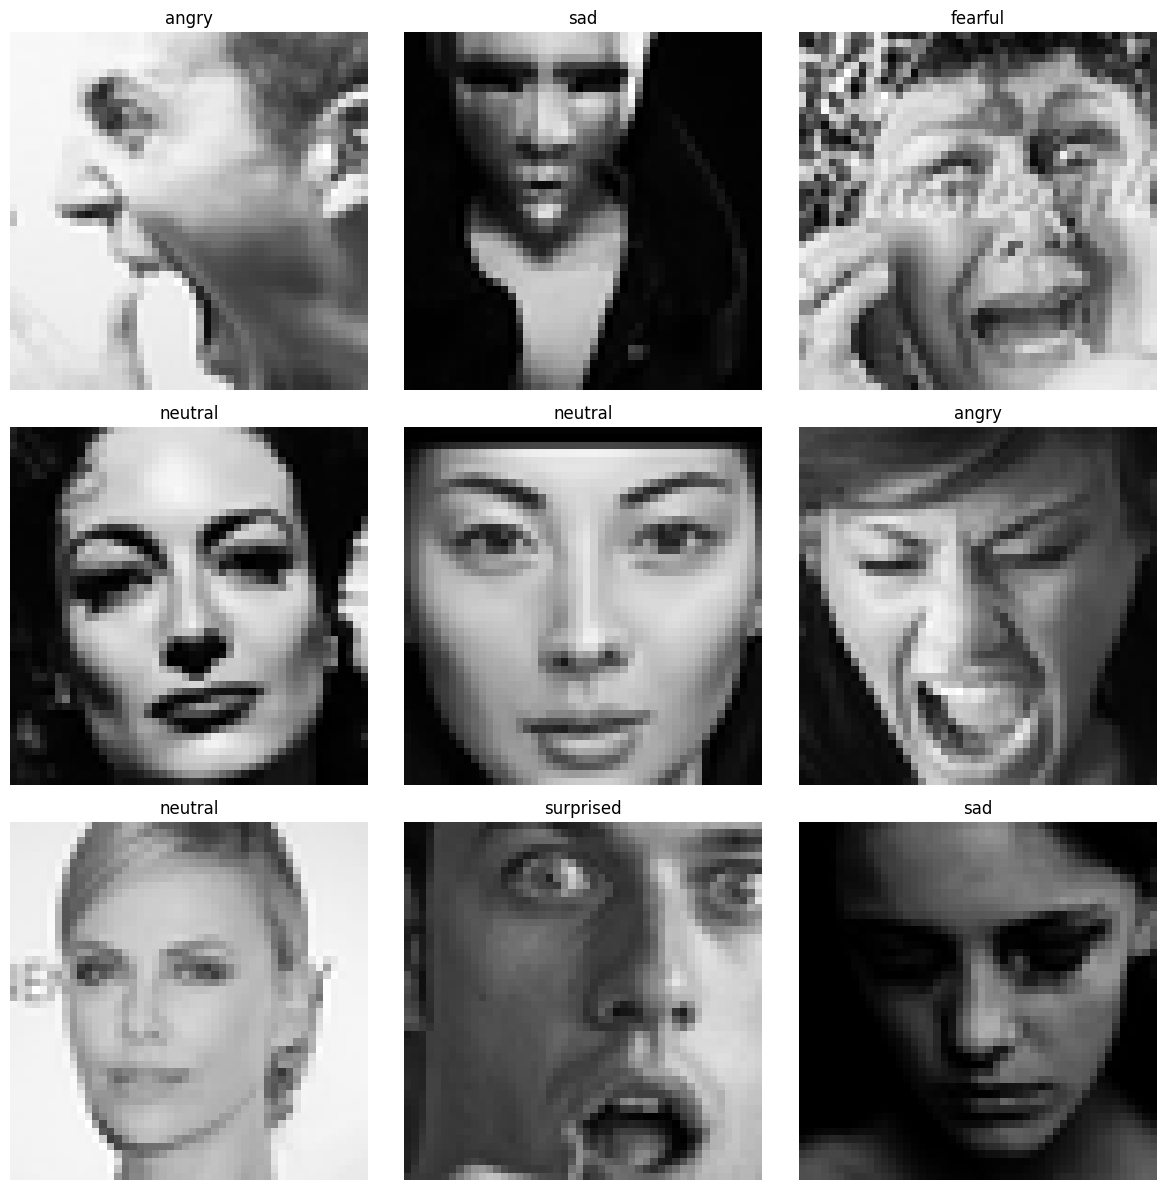

In [6]:
# Plot images
img_datagen = ImageDataGenerator(rescale = 1./255)
img_generator = img_datagen.flow_from_directory(directory=train_dir,
                                                target_size=(img_height,img_width),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                color_mode="rgb",
                                                class_mode="categorical",
                                                seed=random_seed
                                               )
clear_output()

plot_images(img_generator, num_images=9)

# Train Model without Finetuning

In [7]:
base_model = tf.keras.applications.VGG16(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights="imagenet")

In [8]:
base_model.trainable = False

In [9]:
x = base_model.output

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(x) 
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [10]:
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       1,050,6

 Total params: 18,391,879 (70.16 MB)

 Trainable params: 3,677,191 (14.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_layer  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d  Trainable = True
dense  Trainable = True
dropout  Trainable = True
dense_1  Trainable = True
dropout_1  Trainable = True
dense_2  Trainable = True
dense_3  Trainable = True


# Training Model
We will stop learning prematurely if there is no noticeable improvement in validation loss for a couple of epochs.

Before early stopping, there will be a callback to reduce the learning rate to try to maximise the learning as much as possible.

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=early_stop_criteria,
                                                  verbose=1,
                                                  restore_best_weights=True
                                                 )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=np.floor(early_stop_criteria/2),
                                                 verbose=1,
                                                 min_lr=learning_rate*0.1)

In [14]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history = model.fit(x=train_dataset,
                    epochs=num_epochs,
                    validation_data=val_dataset, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 107s 117ms/step - accuracy: 0.2978 - loss: 2.8700 - val_accuracy: 0.3643 - val_loss: 1.6115 - learning_rate: 0.0010
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 103s 115ms/step - accuracy: 0.3739 - loss: 1.6093 - val_accuracy: 0.4040 - val_loss: 1.5522 - learning_rate: 0.0010
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 110s 123ms/step - accuracy: 0.3995 - loss: 1.5574 - val_accuracy: 0.3965 - val_loss: 1.5415 - learning_rate: 0.0010
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 106s 118ms/step - accuracy: 0.4028 - loss: 1.5521 - val_accuracy: 0.4087 - val_loss: 1.5333 - learning_rate: 0.0010
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 102s 114ms/step - accuracy: 0.4081 - loss: 1.5384 - val_accuracy: 0.4227 - val_loss: 1.5129 - learning_rate: 0.0010
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 107s 119ms/step - accuracy: 0.4165 - loss: 1.5233 - val_accuracy: 0.4232 - val_loss: 1.5257 - learning_rate: 0.0010
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy:

In [16]:
metrics = model.evaluate(val_dataset)
print("Non-finetuned Model Accuracy:", metrics[1])

225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.4464 - loss: 1.4536
Non-finetuned Model Accuracy: 0.45723041892051697


In [19]:
model.save('models/emotion_classification_model_VGG16_no_finetune.keras')

Not optimal results, but at least it's still better than random guessing at 14% (1 / 7 classes).

# Finetuning Model
Now let us try training with a finetuned model with the last block of the base VGG model unfrozen.

Like the previous training run, we will have early stopping and reduce learning rate callbacks.

In [20]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_layer  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = True
block5_conv2  Trainable = True
block5_conv3  Trainable = True
block5_pool  Trainable = True
global_average_pooling2d  Trainable = True
dense  Trainable = True
dropout  Trainable = True
dense_1  Trainable = True
dropout_1  Trainable = True
dense_2  Trainable = True
dense_3  Trainable = True


In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=early_stop_criteria,
                                                  verbose=1,
                                                  restore_best_weights=True
                                                 )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.5,
                                                 patience=np.floor(early_stop_criteria/2),
                                                 verbose=1,
                                                 min_lr=finetuning_learning_rate*0.1)

In [23]:
opt = tf.keras.optimizers.Adam(learning_rate=finetuning_learning_rate)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
history = model.fit(x=train_dataset,
                    epochs=num_finetuning_epochs,
                    validation_data=val_dataset, 
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 167s 182ms/step - accuracy: 0.4157 - loss: 1.5379 - val_accuracy: 0.4785 - val_loss: 1.3541 - learning_rate: 1.0000e-04
Epoch 2/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 158s 176ms/step - accuracy: 0.4865 - loss: 1.3538 - val_accuracy: 0.4985 - val_loss: 1.3151 - learning_rate: 1.0000e-04
Epoch 3/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 160s 178ms/step - accuracy: 0.5237 - loss: 1.2691 - val_accuracy: 0.5152 - val_loss: 1.2591 - learning_rate: 1.0000e-04
Epoch 4/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 159s 176ms/step - accuracy: 0.5431 - loss: 1.2075 - val_accuracy: 0.5456 - val_loss: 1.2071 - learning_rate: 1.0000e-04
Epoch 5/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 160s 178ms/step - accuracy: 0.5633 - loss: 1.1564 - val_accuracy: 0.5525 - val_loss: 1.1708 - learning_rate: 1.0000e-04
Epoch 6/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 159s 177ms/step - accuracy: 0.5789 - loss: 1.1214 - val_accuracy: 0.5609 - val_loss: 1.1829 - learning_rate: 1.0000e-04
Epoch 7/25
898/898 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
metrics = model.evaluate(val_dataset)
print("Finetuned Model (Unfrozen Block 5 Layers_ Accuracy:", metrics[1])

225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - accuracy: 0.6012 - loss: 1.1484
Finetuned Model (Unfrozen Block 5 Layers_ Accuracy: 0.6012817025184631


In [26]:
model.save('models/emotion_classification_model_VGG16_finetune_block5.keras')

A ~15% improvement from the model which was not finetuned. Still not a fantastic result, but it seems like finetuning was a great idea!

# Inference

Now we test the models on a fresh set of images. 

The images are obtained from Google and are in RGB, so we have to be mindful to convert these images to greyscale first then increase it's dimensions to 3, because that was the type of images used for training.

In [27]:
from keras.preprocessing import image
import cv2

In [28]:
img_dir_path = 'data/emotion_dataset/'
img_names = ['inference_neutral', 'inference_surprised', 'inference_angry', 'inference_sad']
img_true_labels = ['neutral', 'surrpised', 'angry', 'sad']

img_paths = []
for img_name in img_names:
    img_paths.append(f"{img_dir_path}{img_name}.jpg")

In [29]:
# Load the saved models
no_finetune_model = tf.keras.models.load_model('models/emotion_classification_model_VGG16_no_finetune.keras')
finetuned_model = tf.keras.models.load_model('models/emotion_classification_model_VGG16_finetune_block5.keras')

In [30]:
no_finetune_preds = []
finetuned_preds = []

# Perform inference
for img_path in img_paths:
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)      # Convert RGB to grayscale
    img = np.stack([img, img, img], axis=-1)                   # Expand dimensions to simulate RGB channels
    img_array = image.img_to_array(img)                        # Convert the image to a numpy array
    img_array = np.expand_dims(img_array, axis=0)              # Add batch dimension (the model expects shape (batch_size, 48, 48, 3))
    preprocessed_img = tf.keras.applications.vgg16.preprocess_input(img_array)
    print(preprocessed_img.shape)
    
    no_finetune_preds.append(no_finetune_model.predict(preprocessed_img))
    finetuned_preds.append(finetuned_model.predict(preprocessed_img))

(1, 48, 48, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
(1, 48, 48, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
(1, 48, 48, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
(1, 48, 48, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [31]:
no_finetune_preds_labels = []
finetuned_preds_labels = []

# Get the predicted class index and label
for no_finetune_pred in no_finetune_preds:
    no_finetune_pred_class_index = np.argmax(no_finetune_pred, axis=1)[0]
    no_finetune_pred_class_label = class_labels[no_finetune_pred_class_index]
    no_finetune_preds_labels.append(no_finetune_pred_class_label)

for finetuned_pred in finetuned_preds:
    finetuned_pred_class_index = np.argmax(finetuned_pred, axis=1)[0]
    finetuned_pred_class_label = class_labels[finetuned_pred_class_index]
    finetuned_preds_labels.append(finetuned_pred_class_label)

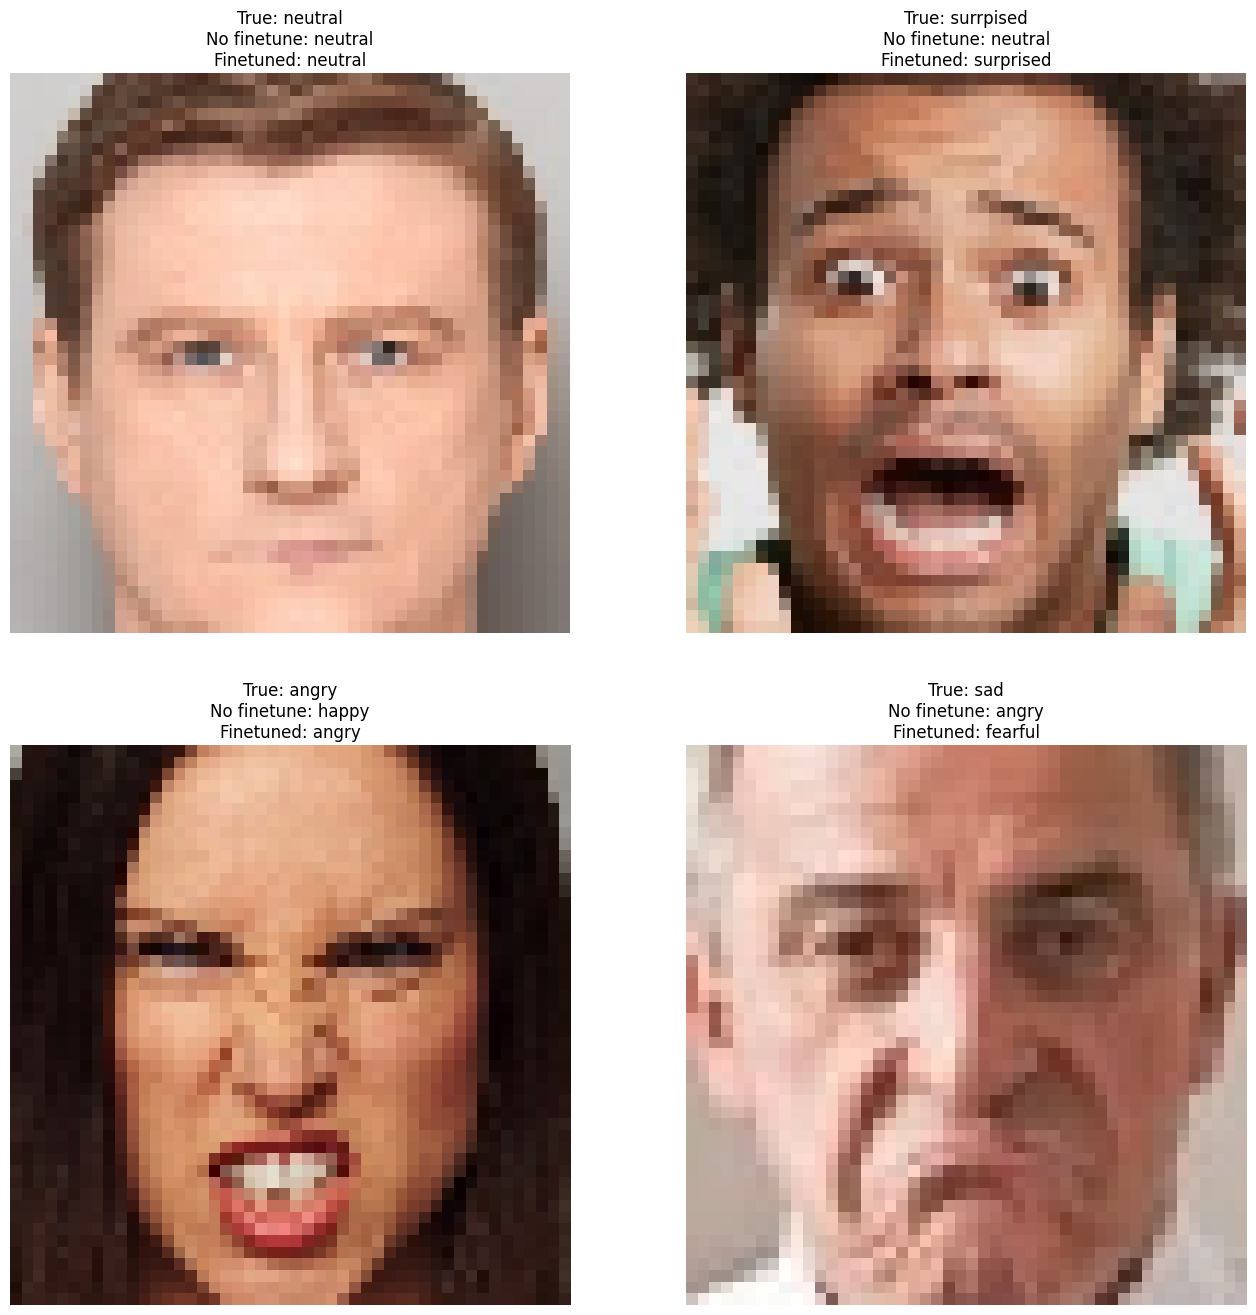

In [32]:
# Define the number of images to display in a grid
num_images = len(img_paths)
num_rows = int(num_images ** 0.5)
num_cols = (num_images + num_rows - 1) // num_rows
    
# Create a figure with subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 16))
    
for i in range(num_images):
    true_label = img_true_labels[i]
    no_finetune_pred_label = no_finetune_preds_labels[i]
    finetuned_pred_label = finetuned_preds_labels[i]  
    img = image.load_img(img_paths[i], target_size=(img_height, img_width))
    
    ax = axes[i // num_cols, i % num_cols]
    ax.imshow(img)
    ax.axis('off')  # Hide axis
    ax.set_title(f"True: {true_label}\n"
        f"No finetune: {no_finetune_pred_label}\n"
        f"Finetuned: {finetuned_pred_label}")  # Display label

The finetuned model got 3 out of 4 right, while the the non-finetuned model got 1 out of 4 right. Nice!

Now I can use the finetuned model to decipher what my partner's emotions are. Awesome!